In [ ]:
#!pip install PyPDF2
#!pip install tinydb
#!pip install langchain
#!pip install langchain-community
#!pip install pandas
#!pip install python-dotenv


## LLM AZURE

In [29]:
# %% [code]
import os
from dotenv import load_dotenv
#from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import PyPDF2
from tinydb import TinyDB, Query
from langchain.chat_models import AzureChatOpenAI

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Recuperar las variables
openai_api_base = os.getenv("OPENAI_API_BASE")
openai_api_key = os.getenv("OPENAI_API_KEY")
openai_api_version = os.getenv("OPENAI_API_VERSION")
deployment_name = os.getenv("DEPLOYMENT_NAME")

# Inicializar el LLM usando las variables de entorno
llm = AzureChatOpenAI(
    openai_api_base=openai_api_base,
    openai_api_key=openai_api_key,
    openai_api_version=openai_api_version,
    deployment_name=deployment_name,
    temperature=0.2
)

# Inicialización de TinyDB (la base se almacenará en el archivo history.json)
db = TinyDB("ResCTM.json")
records_table = db.table("records")


/Users/joaquintschopp/ProyectosPY/AgentesAI/.venv/lib/python3.13/site-packages/langchain_community/chat_models/azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://sg-openai.openai.azure.com/ to https://sg-openai.openai.azure.com/openai.
  warnings.warn(
/Users/joaquintschopp/ProyectosPY/AgentesAI/.venv/lib/python3.13/site-packages/langchain_community/chat_models/azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specified then `openai_api_base` (or alias `base_url`) should not be. Instead use `deployment_name` (or alias `azure_deployment`) and `azure_endpoint`.
  warnings.warn(
/Users/joaquintschopp/ProyectosPY/AgentesAI/.venv/lib/python3.13/site-packages/langchain_community/chat_models/azure_openai.py:189: UserWarning: As of openai>=1.0.0, if `openai_api_base` (or alias `base

## LLM InSitu Ollama Llama3.2 3billones

In [ ]:
# %% [code]
import os
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import PyPDF2
from tinydb import TinyDB, Query
from langchain.llms import Ollama

# Configuración del LLM para usar Ollama en la red interna
llm = Ollama(
    model="llama3.2:latest",
    base_url="http://10.209.0.140:11434",  # Ajusta la IP y el puerto según tu configuración
    temperature=0.2
)

# Inicialización de TinyDB (la base se almacenará en el archivo ResCTM.json)
db = TinyDB("ResCTM.json")
records_table = db.table("records")


# Funciones de procesamiento

In [16]:
# %% [code]
def pdf_to_text(pdf_path):
    """
    Extrae el texto de un archivo PDF utilizando PyPDF2.
    """
    text = ""
    with open(pdf_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text


# 1. Corrección de la transcripción usando LangChain

In [17]:
# %% [code]
correction_prompt = PromptTemplate(
    input_variables=["text"],
    template="Corrige la transcripción del siguiente texto:\n\n{text}\n\nTexto corregido:"
)

def correct_transcription(text):
    """
    Utiliza un LLM para corregir la transcripción extraída del PDF.
    """
    chain = LLMChain(llm=llm, prompt=correction_prompt)
    corrected = chain.run(text=text)
    return corrected


# 2. Extracción de datos y generación del resumen

In [18]:
# Prompt adaptado con instrucciones específicas
extraction_prompt = PromptTemplate(
    input_variables=["text", "template_info"],
    template=(
        "Utilizando el siguiente template:\n"
        "{template_info}\n\n"
        "Extrae únicamente los datos solicitados y genera un resumen ejecutivo breve (máximo 30 palabras) "
        "del tema principal del texto, sin incluir detalles menores ni secundarios.\n\n"
        "Texto:\n{text}\n\n"
        "Datos extraídos y resumen ejecutivo breve:"
    )
)

def extract_data_summary(text, extraction_template):
    """
    Extrae datos específicos y genera un resumen ejecutivo breve.
    """
    chain = LLMChain(llm=llm, prompt=extraction_prompt)
    result = chain.run(text=text, template_info=extraction_template)
    return result


# 3. Clasificación de la resolución

In [19]:
CATEGORIAS_CTMSG = {
    "Reglamentación y Normativas": [
        "REGLAMENTO",
        "MANUAL DE NORMA",
        "MANUAL Normas Compras y Contrataciones",
        "NORMA ISO",
        "LICENCIA ESPECIAL",
        "ESTATUTO DEL PERSONAL",
        "SUMARIO ADMINISTRATIVO"
    ],
    "Administración Financiera y Contable": [
        "REMUNERACIONES",
        "REGISTRACION CONTABLE",
        "BALANCES",
        "BANCOS",
        "PRESUPUESTOS",
        "TARIFAS ENERGÍA"
    ],
    "Contrataciones y Convenios": [
        "CONVENIO",
        "CONTRATACIONES Y COMPRAS",
        "COMPRAS AUTOMOTORES",
        "CONCURSOS PRECIOS",
        "PODERES ABOGADOS"
    ],
    "Infraestructura y Mantenimiento": [
        "EDIFICIOS",
        "VIVIENDAS",
        "EQUIPAMIENTO REPRESA",
        "MANTENIMIENTO",
        "TRANSFORMADORES",
        "SEGURIDAD PRESA",
        "PUERTO SECO"
    ],
    "Servicios Médicos y Sociales": [
        "PRESTAMOS PERSONAL",
        "SERVICIOS MÉDICOS",
        "ATENCIÓN MÉDICA",
        "SEGUROS VIDA"
    ],
    "Comunicaciones y Relaciones Institucionales": [
        "RELACIONES PÚBLICAS",
        "COMUNICACIÓN INSTITUCIONAL",
        "PUBLICIDAD",
        "LOGOTIPO",
        "FIRMA DIGITAL",
        "PAGINA WEB"
    ],
    "Auditorías y Control Interno": [
        "AUDITORIA INTERNA",
        "AUDITORÍA EXTERNA",
        "CONTROL GESTIÓN"
    ],
    "Recursos Humanos": [
        "CONTROL ASISTENCIA",
        "EPIDEMIOLOGÍA",
        "CURSOS Y SEMINARIOS",
        "DESVINCULACIONES"
    ],
    "Ambiental y Social": [
        "RIBEREÑOS",
        "MERCOSUR",
        "MERCADOS ELÉCTRICOS",
        "CULTURALES",
        "SAOTTA"
    ],
    "Gestión y Operaciones": [
        "DIRECCIÓN EJECUTIVA",
        "GERENCIA",
        "DELEGACIONES",
        "TAISG",
        "HORARIOS OFICINAS",
        "GRUPOS TRABAJO",
        "CENTRO DOCUMENTACIÓN",
        "RENOVACIÓN SALTO GRANDE"
    ]
}


In [20]:
# Prompt adaptado
classification_prompt = PromptTemplate(
    input_variables=["text", "data_summary", "categorias"],
    template=(
        "Basándote en el siguiente texto y en los datos extraídos y resumen:\n\n"
        "Texto: {text}\n\n"
        "Datos y resumen: {data_summary}\n\n"
        "Considerando estas categorías disponibles: {categorias}\n\n"
        "Clasifica la resolución estrictamente dentro de una de estas categorías principales."
    )
)

# Función ajustada
def classify_resolution(text, data_summary):
    categorias_str = ', '.join(CATEGORIAS_CTMSG.keys())
    chain = LLMChain(llm=llm, prompt=classification_prompt)
    classification = chain.run(text=text, data_summary=data_summary, categorias=categorias_str)
    return classification


# Función principal para procesar el PDF y guardar la información en TinyDB

In [21]:
import re

def parse_data_summary(data_summary):
    """
    Divide el resumen extraído en campos separados.
    """
    fields = ["Número de resolución", "Fecha", "Ente emisor", "Resumen ejecutivo breve"]
    parsed_data = {}

    for field in fields:
        pattern = rf"{field}:\s*(.+)"
        match = re.search(pattern, data_summary)
        if match:
            parsed_data[field] = match.group(1).strip()
        else:
            parsed_data[field] = None

    return parsed_data

In [22]:
# %% [code]
def process_pdf(pdf_path, extraction_template, db_table):
    """
    Procesa un archivo PDF completo: extrae el texto, lo corrige,
    extrae datos y resumen, clasifica la resolución y guarda todo en TinyDB.
    """
    file_name = os.path.basename(pdf_path)
    
    # Verificar si el documento ya se encuentra en la base de datos
    Record = Query()
    if db_table.search(Record.pdf_file == file_name):
        print(f"El documento {file_name} ya se encuentra registrado en TinyDB.")
        return

    # Extracción de texto
    raw_text = pdf_to_text(pdf_path)
    print(f"Texto extraído del archivo {file_name}.")
    
    # Corrección de la transcripción
    corrected_text = correct_transcription(raw_text)
    print("Transcripción corregida.")
    
    # Extracción de datos y resumen
    extracted_result = extract_data_summary(corrected_text, extraction_template)
    print("Datos y resumen extraídos.")
    
    # Clasificación de la resolución
    classification = classify_resolution(corrected_text, extracted_result)
    print("Clasificación realizada.")
    
    # Crear el registro con la información resultante
    parsed_summary = parse_data_summary(extracted_result)

    record = {
        "pdf_file": file_name,
        "text": corrected_text,
        "numero_resolucion": parsed_summary["Número de resolución"],
        "fecha": parsed_summary["Fecha"],
        "ente_emisor": parsed_summary["Ente emisor"],
        "resumen_ejecutivo": parsed_summary["Resumen ejecutivo breve"],
        "classification": classification
    }
    
    # Guardar el registro en TinyDB
    db_table.insert(record)
    print(f"El documento {file_name} ha sido registrado en TinyDB.")

    return record


# Ejecución del procesamiento

In [23]:
# %% [code]
# Template explícito para extracción
extraction_template = (
    "- Número de resolución:\n"
    "- Fecha:\n"
    "- Ente emisor:\n"
    "- Resumen ejecutivo breve (máximo 30 palabras, tema principal solamente):"
)

# Carpeta donde se encuentran los archivos PDF
pdf_folder = "pdfs"  # Asegúrate de tener esta carpeta y colocar allí tus PDFs

# Procesar cada PDF nuevo en la carpeta
for file_name in os.listdir(pdf_folder):
    if file_name.lower().endswith(".pdf"):
        pdf_path = os.path.join(pdf_folder, file_name)
        process_pdf(pdf_path, extraction_template, records_table)


El documento res00222.pdf ya se encuentra registrado en TinyDB.
El documento res00122.pdf ya se encuentra registrado en TinyDB.


# Función para procesar un nuevo PDF individualmente

In [25]:
# %% [code]
def procesar_nuevo_pdf(pdf_path, extraction_template, db_table):
    """
    Procesa un nuevo PDF individualmente y lo añade a la base de datos TinyDB.
    """
        # Crear el registro con la información resultante
    record = {
        "pdf_file": "New Resolucion",
        "text": "corrected_text",
        "data_summary": "extracted_result",
        "classification": "classification"
    }

    file_name = os.path.basename(pdf_path)
    Record = Query()
    if db_table.search(Record.pdf_file == file_name):
        print(f"El documento {file_name} ya se encuentra registrado.")
        return
    else:
        record = process_pdf(pdf_path, extraction_template, db_table)
        print(record)
        

#Ejemplo de llamada para procesar un nuevo PDF:
nuevo_pdf = "pdfs/new/res00522.pdf"
procesar_nuevo_pdf(nuevo_pdf, extraction_template, records_table)



Texto extraído del archivo res00522.pdf.
Transcripción corregida.
Datos y resumen extraídos.
Clasificación realizada.
El documento res00522.pdf ha sido registrado en TinyDB.
{'pdf_file': 'res00522.pdf', 'text': 'COMISIÓN TÉCNICA MIXTA DE SALTO GRANDE  \nVideoconferencia, 26 de enero de 2022  \nRESOLUCIÓN CTM Nº 005/22 (Acta Nº 1127 - as. 8.4) \n\nVISTO: el EE 2021-AECO-0179, mediante el cual en la actuación 7 la Gerencia General manifiesta interés de suscribir un Convenio Específico entre la C.T.M.S.G. y la Estación Experimental de la Facultad de Agronomía en Salto, enmarcado dentro del Convenio Marco suscripto con la Facultad de Agronomía de la Universidad de la República Oriental del Uruguay, con el objeto de asistencia y/o colaboración e intercambio recíproco, destinado a la realización de tareas de investigación, capacitación, valorización y conservación de recursos genéticos, potenciar el uso de especies nativas en diferentes áreas productivas mediante la implementación de un sist

# Inspeccion de DB

In [27]:
import pandas as pd

db = TinyDB("ResCTM.json")
records_table = db.table("records")

registro_4 = records_table.get(doc_id=5)
if registro_4:
    for campo, valor in registro_4.items():
        print(f"{campo}:")
        if isinstance(valor, str) and len(valor) > 150:
            print(valor[:300] + "...")
        else:
            print(valor)
        print("-" * 50)
else:
    print("Registro no encontrado.")

print(registro_4)

pdf_file:
res00522.pdf
--------------------------------------------------
text:
COMISIÓN TÉCNICA MIXTA DE SALTO GRANDE  
Videoconferencia, 26 de enero de 2022  
RESOLUCIÓN CTM Nº 005/22 (Acta Nº 1127 - as. 8.4) 

VISTO: el EE 2021-AECO-0179, mediante el cual en la actuación 7 la Gerencia General manifiesta interés de suscribir un Convenio Específico entre la C.T.M.S.G. y la Est...
--------------------------------------------------
numero_resolucion:
CTM Nº 005/22
--------------------------------------------------
fecha:
26 de enero de 2022
--------------------------------------------------
ente_emisor:
Comisión Técnica Mixta de Salto Grande
--------------------------------------------------
resumen_ejecutivo:
Autorización de un convenio específico con la Estación Experimental de la Facultad de Agronomía en Salto para investigación y propagación de especies nativas....
--------------------------------------------------
classification:
La resolución CTM Nº 005/22 se clasifica estrictamen

In [13]:
#db = TinyDB('historial.json')
#db.truncate()  # Esto vacía completamente la base de datos
#db.close()

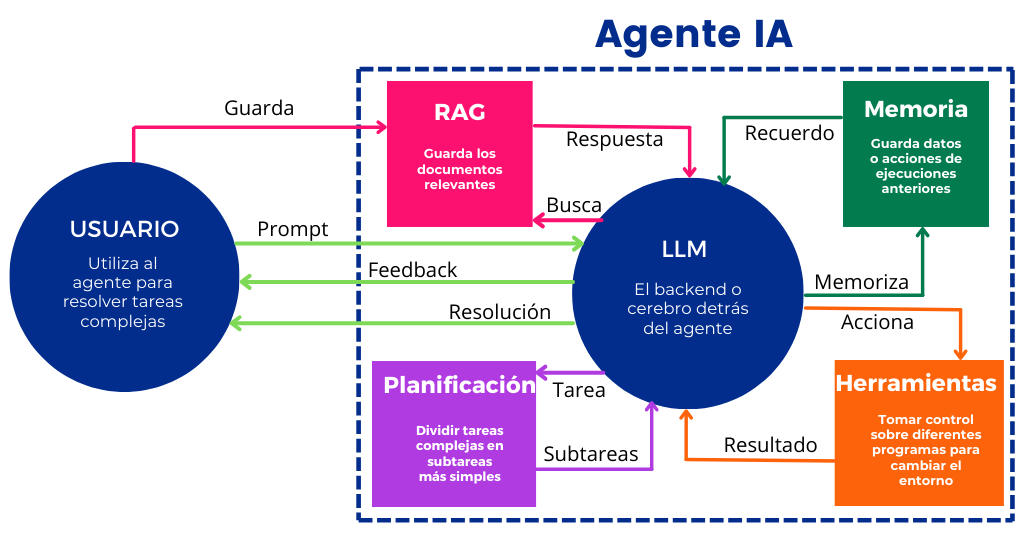